In [1]:
import pandas as pd
import numpy as np
import tarfile
import gzip
import glob
import matplotlib.pyplot as plt

## Read

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
meta = 'data/batches.meta'
meta = unpickle(meta)

In [4]:
# read train and test
file_list = glob.glob('data/data_*')
file_list.extend(glob.glob('data/test*'))

In [5]:
data = []
labels = []

# merge train and test set
for file in file_list:
    temp = unpickle(file)
    data_temp = temp.get(b'data')
    labels_temp = temp.get(b'labels')
    
    # append as list
    data.append(data_temp)
    labels.append(labels_temp)

In [6]:
# reshape as (60000, 32, 32, 3)
n = 60000
cifar = np.array(data).reshape(n, -1)
cifar_labels = np.array(labels).reshape(n)

## Plot

In [7]:
def cif_plot(data, title=''):
    # reshape img
    img = data.reshape(3,32,32)
    
    # plot
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.imshow(np.transpose(img, (1, 2, 0)))
    
    return ax

[]

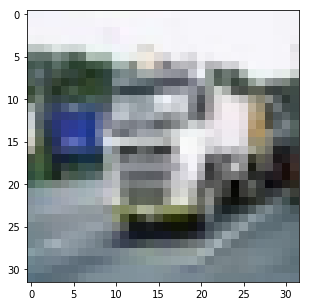

In [8]:
cif_plot(cifar[1000]).plot()

## Part A

In [9]:
# 1. get mean image
# get unique labels
labels = np.unique(cifar_labels)

# groupby data and get mean
idx_data = [cifar[cifar_labels==label] for label in labels]
mean_data = [np.mean(data,0) for data in idx_data]

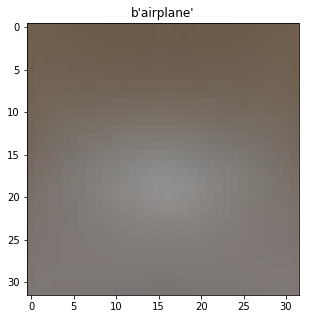

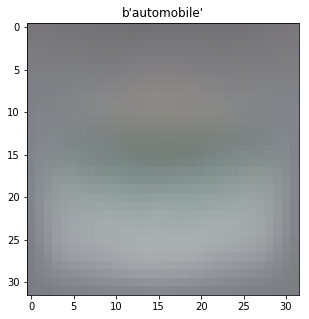

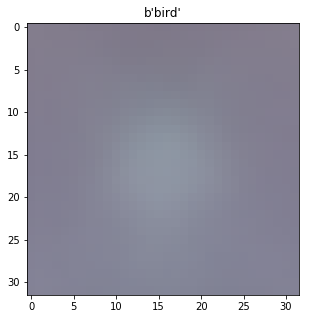

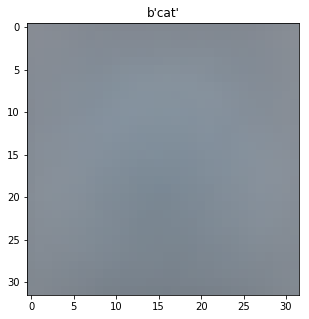

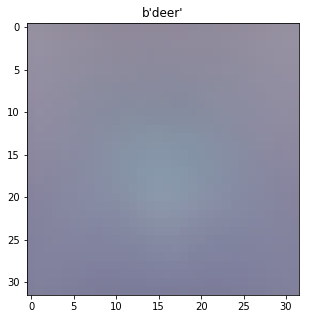

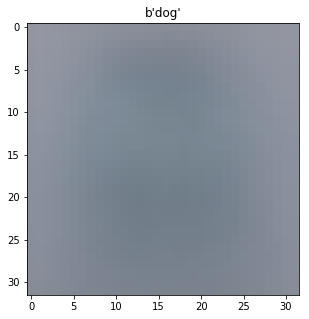

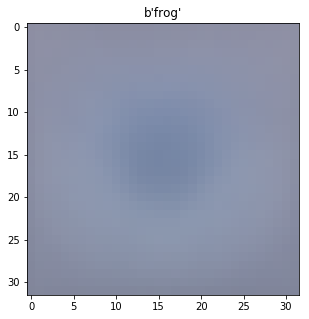

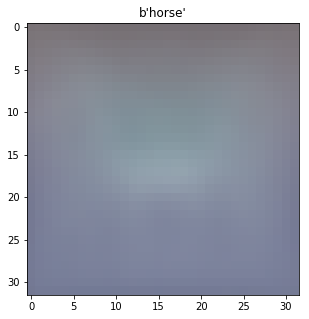

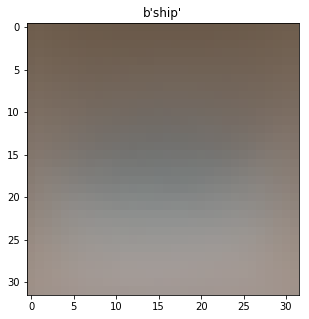

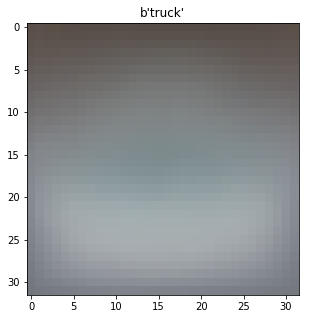

In [10]:
# plot mean image
for data, i in zip(mean_data, np.arange(10)):
    cif_plot(np.round(data),meta.get(b'label_names')[i])
#temp = np.round(mean_data[0].reshape(3,32,32))
#plt.imshow(np.transpose(temp, (1,2,0)))

In [11]:
# 1. compute 20 principals
from sklearn.decomposition import PCA

components_list = [PCA(n_components=20).fit(data-mean).components_ for data, mean in zip(idx_data, mean_data)]

In [12]:
# 2. use pc and mean to reconstruction
# data shape 6000, 3072
# comp shape 20, 3072

recon = [np.dot(np.dot(data-mean, comp.T), comp)+mean for data, comp, mean in zip(idx_data, components_list, mean_data)]

In [13]:
# 3. compute the squared difference between the original and reconstructed version,
# and sum this over all pixels over all channels. If you have flattened your images, this is simply 
# the squared euclidean distance between the image vectors. 
# Take the average of the value you computed above over all images in the class.

from sklearn.metrics import euclidean_distances

dist = [np.sum(np.subtract(x, xhat)**2,1) for x, xhat in zip(idx_data, recon)]

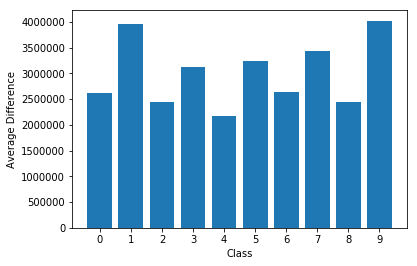

In [14]:
# 4. Plot the above value in the bar graph against its category/class label.

plt.bar(labels,np.mean(dist,1))
plt.xlabel('Class')
plt.ylabel('Average Difference')
plt.xticks(np.arange(10))
plt.show()

## Part B

In [15]:
# order
#    "0" : "airplane",
#    "1": "automobile", 
#    "2": "bird", 
#    "3": "cat", 
#    "4": "deer", 
#    "5": "dog", 
#    "6": "frog", 
#    "7": "horse", 
#    "8": "ship", 
#    "9": "truck"

In [16]:
# 1. Compute a 10 x 10 distance matrix D such that D[i,j] is the Euclidean distance 
# between the mean images of class i and class j. 
# Square the elements of this matrix and write it out to a CSV file named partb_distances.csv

# outer loop goes first(img2)
D = [np.sum(np.subtract(img1, img2)**2) for img1 in mean_data for img2 in mean_data]
D = np.array(D).reshape(-1,10)

# save (correct!)
pd.DataFrame(D).to_csv('partb_distances.csv', index=None, header=None)

In [17]:
# 2. Now you must perform multi-dimensional scaling with the squared distance matrix you have. 
# Refer to the MDS section for details on how to do that.

d=10
A = np.identity(d)-np.dot(np.ones((d,1)), np.ones((1,d)))/d
XXT = -2*np.dot(np.dot(A, D), A.T)/2
eigval, eigvec = np.linalg.eig(XXT)

idx = np.argsort(-eigval)
eigval = eigval[idx]
eigvec = eigvec[:, idx]

[]

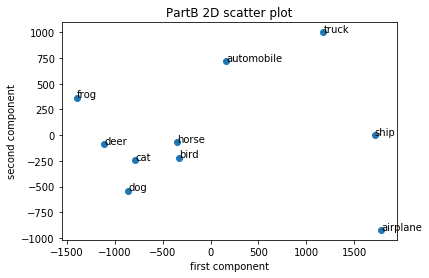

In [37]:
# 3. Once you have computed the scaled points in 2-D space, 
# plot the first component along the x-axis and component 2 along the y-axis of a scatter plot.
# You will submit this plot.
ys = eigvec[:,0:2]* np.sqrt(eigval[0:2])
fig, ax = plt.subplots()
for i, txt in enumerate(meta.get(b'label_names')):
    ax.annotate(txt.decode('utf-8'), (ys[i,0], ys[i,1]))

    
plt.scatter(ys[:,0], ys[:,1])

plt.title('PartB 2D scatter plot')
plt.xlabel('first component')
plt.ylabel('second component')
plt.plot()

## Part C

In [38]:
mean = mean_data[0]
comp = components_list[0]
data = idx_data[0]
np.sum((data-np.dot(np.dot(data-mean, comp.T), comp)+mean)**2,1).shape

(6000,)

In [39]:
# 1. Just like in Part B, you will first compute a 10 x 10 distance matrix. 
# However, here, D[i,j] will contain E(i → j). Let's define E(A → B).

# 100 x 6000
cdist = [np.sum(np.subtract(data, np.dot(np.dot(data-mean, comp.T), comp)+mean)**2,1) for data, mean in zip(idx_data, mean_data) for comp in components_list]

# 100 x 1
mean_dist = np.mean(np.array(cdist),1)


In [40]:
mean_dist = np.array(mean_dist).reshape(10,10)

# compute dist
dist_mat = np.zeros((10,10))
for i in np.arange(10):
    for j in np.arange(10):
        dist = (mean_dist[i,j]+mean_dist[j,i])/2
        dist_mat[i,j] = dist

In [41]:
# 2. save
pd.DataFrame(dist_mat).to_csv('partc_distances.csv', index=None, header=None)

In [42]:
# 3. Perform MDS with this distance matrix, and once you have the scaled points in 2-D, 
# plot the first component along the x-axis and component 2 along the y-axis of a scatter plot.
# You will submit this plot.

d=10
A = np.identity(d)-np.dot(np.ones((d,1)), np.ones((1,d)))/d
XXT = -2*np.dot(np.dot(A, dist_mat), A.T)/2
eigval, eigvec = np.linalg.eig(XXT)

idx = np.argsort(-eigval)
eigval = eigval[idx]
eigvec = eigvec[:, idx]

[]

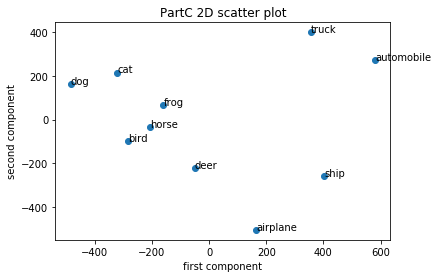

In [44]:
# compute y
ys = eigvec[:,0:2]* np.sqrt(eigval[0:2])
# plot

fig, ax = plt.subplots()
for i, txt in enumerate(meta.get(b'label_names')):
    ax.annotate(txt.decode('utf-8'), (ys[i,0], ys[i,1]))

plt.scatter(ys[:,0], ys[:,1])

plt.title('PartC 2D scatter plot')
plt.xlabel('first component')
plt.ylabel('second component')
plt.plot()